In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
import argparse
import os
from tensorflow.keras.applications import ResNet50V2

In [ ]:
import numpy as np

data=np.load('/content/drive/MyDrive/deeplearningproject/ArrayData/data.npy')
labels=np.load('/content/drive/MyDrive/deeplearningproject/ArrayData/labels.npy')

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
testY

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
aug = ImageDataGenerator(
  featurewise_center=False,  
  samplewise_center=False,  
  featurewise_std_normalization=False,  
  samplewise_std_normalization=False,  
  zca_whitening=False,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
IMG_SIZE = 224
CHANNELS = 3
N_LABELS=2

feature_extractor_layer = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Flatten(name="flatten"),
    layers.Dense(128, activation='relu', name='hidden_layer'),
    layers.Dropout(0.5),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
hidden_layer (Dense)         (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 36,410,242
Trainable params: 12,845,442
Non-trainable params: 23,564,800
_________________________________________________________________


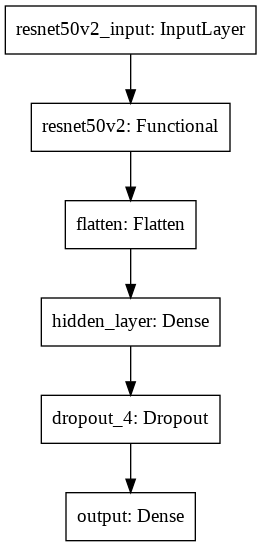

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
LR = 1e-4 # öğrenme oranı
EPOCHS = 20
BS = 32

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss="binary_crossentropy",
  metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [ ]:
history = model.fit(aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
  callbacks=[early_stopping],
	validation_data=(testX, testY),
	epochs=EPOCHS)

Epoch 1/20
188/188 [==============================] - 125s 485ms/step - loss: 0.1789 - accuracy: 0.9511 - val_loss: 0.0349 - val_accuracy: 0.9894
Epoch 2/20
188/188 [==============================] - 86s 458ms/step - loss: 0.0530 - accuracy: 0.9825 - val_loss: 0.0348 - val_accuracy: 0.9894
Epoch 3/20
188/188 [==============================] - 87s 461ms/step - loss: 0.0434 - accuracy: 0.9903 - val_loss: 0.0473 - val_accuracy: 0.9848
Epoch 4/20
188/188 [==============================] - 87s 464ms/step - loss: 0.0420 - accuracy: 0.9896 - val_loss: 0.0258 - val_accuracy: 0.9954
Epoch 5/20
188/188 [==============================] - 87s 465ms/step - loss: 0.0359 - accuracy: 0.9924 - val_loss: 0.0279 - val_accuracy: 0.9967
Epoch 6/20
188/188 [==============================] - 88s 470ms/step - loss: 0.0328 - accuracy: 0.9905 - val_loss: 0.0337 - val_accuracy: 0.9947
Epoch 7/20
188/188 [==============================] - 87s 461ms/step - loss: 0.0327 - accuracy: 0.9927 - val_loss: 0.0274 - val_a

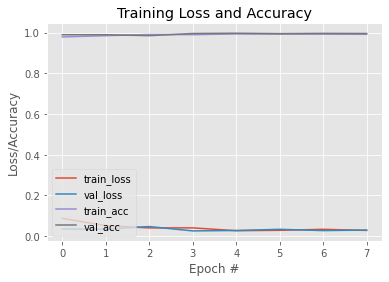

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(history.history["val_loss"])), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(history.history["accuracy"])), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(history.history["val_accuracy"])), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
model.save_weights('/content/drive/MyDrive/deeplearningproject/ResNet/ResNetModel3.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/deeplearningproject/ResNet/ResNetModel3.h5')

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)
class_names = ['with_mask', 'without_mask']
# find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=class_names))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       745
without_mask       1.00      1.00      1.00       766

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



Text(33.0, 0.5, 'True Labels')

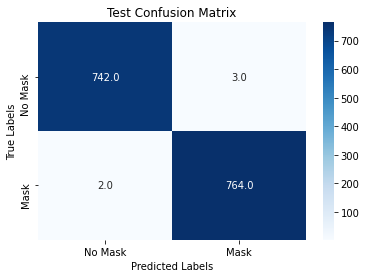

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

import seaborn as sn

predictions = model.predict(testX)
cm2 = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1))

sn.heatmap(cm2,annot=True,fmt = '.1f',xticklabels=['No Mask','Mask'],yticklabels=['No Mask','Mask'],cmap = 'Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

prediction =  model.predict(testX)
fpr, tpr, tresholds = roc_curve(testY.argmax(axis=1), predictions.argmax(axis=1))

Text(0.5, 1.0, 'ROC for mask/no_mask classification\nAUC = 0.997')

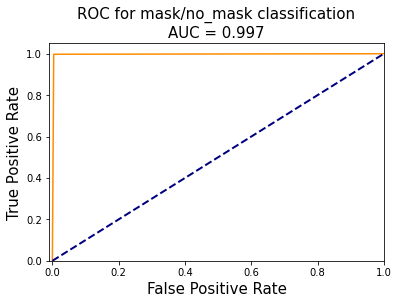

In [ ]:
prediction =  model.predict(testX)
fpr, tpr, tresholds = roc_curve(testY.argmax(axis=1), predictions.argmax(axis=1))
auc = metrics.auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title(f'ROC for mask/no_mask classification\nAUC = {auc:.3f}', size=15)